# Introduction

Nama : Wardatul Fadhilah

Batch : 014

Dataset : Cat and Dog Classification

URL : https://www.kaggle.com/datasets/tongpython/cat-and-dog?select=test_set

Objective : Untuk klasifikasi gambar apakah kucing atau anjing.

# Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import tensorflow as tf
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

Import pustaka yang digunakan pada analisis.

Data Loading

In [2]:
!mkdir -p ~/.kaggle 
#bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [5]:
!kaggle datasets download -d tongpython/cat-and-dog

 97% 212M/218M [00:02<00:00, 144MB/s]
100% 218M/218M [00:02<00:00, 104MB/s]


In [6]:
!unzip -q /content/cat-and-dog.zip -d images

In [8]:
os.listdir('/content/images/cat_dog')

['test_set', 'training_set']

In [9]:
main_path= '/content/images/cat_dog'

In [10]:
train_dir = os.path.join(main_path, 'training_set')
test_dir = os.path.join(main_path, 'test_set')

In [11]:
print('train set: \n' + '='*50)
num_cats= len(os.listdir(os.path.join(train_dir, 'cats')))
num_dogs= len(os.listdir(os.path.join(train_dir, 'dogs')))
print(f'jumlah cats= {num_cats}')
print(f'jumlah dogs= {num_dogs}')

train set: 
jumlah cats= 4001
jumlah dogs= 4006


In [12]:
print('test set: \n' + '='*50)
num_cats= len(os.listdir(os.path.join(test_dir, 'cats')))
num_dogs= len(os.listdir(os.path.join(test_dir, 'dogs')))
print(f'jumlah cats= {num_cats}')
print(f'jumlah dogs= {num_dogs}')

test set: 
jumlah cats= 1012
jumlah dogs= 1013


In [13]:
train_cats = glob.glob(train_dir+"/cats/*.jpg")
train_dogs = glob.glob(train_dir+"/dogs/*.jpg")

test_cats = glob.glob(test_dir+"/cats/*.jpg")
test_dogs = glob.glob(test_dir+"/dogs/*.jpg")

In [14]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))

    return pd.DataFrame(data, columns=['images', 'label'])

main_df = create_dataframe(train_cats + train_dogs)
main_df = main_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [15]:
print(main_df.shape)
main_df

(8005, 2)


,images,label
0,/content/images/cat_dog/training_set/cats/cat....,cats
1,/content/images/cat_dog/training_set/cats/cat....,cats
2,/content/images/cat_dog/training_set/cats/cat....,cats
3,/content/images/cat_dog/training_set/dogs/dog....,dogs
4,/content/images/cat_dog/training_set/cats/cat....,cats
...,...,...
8000,/content/images/cat_dog/training_set/dogs/dog....,dogs
8001,/content/images/cat_dog/training_set/dogs/dog....,dogs
8002,/content/images/cat_dog/training_set/cats/cat....,cats
8003,/content/images/cat_dog/training_set/cats/cat....,cats


Lokasi gambar yang digunakan beserta labelnya.

# EDA

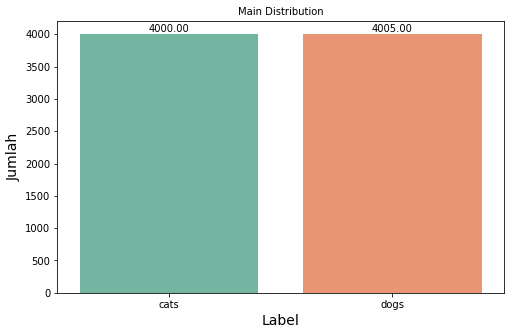

In [16]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(main_df, 'Main')

Visualisasi data diatas menunjukkan cats dan dogs banyak datanya hampir sama.

In [18]:
labels = pathlib.Path(train_dir)
label_names=np.array(sorted([item.name for item in labels.glob('*')]))
print(label_names)

['cats' 'dogs']


In [19]:
# Get few samples for both the classes
cats_samples = (main_df[main_df['label']=="cats"]['images'].iloc[:10]).tolist()
dogs_samples = (main_df[main_df['label']=='dogs']['images'].iloc[:10]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Memisahkan data cats dan dogs ke dalam list untuk visualisasi.

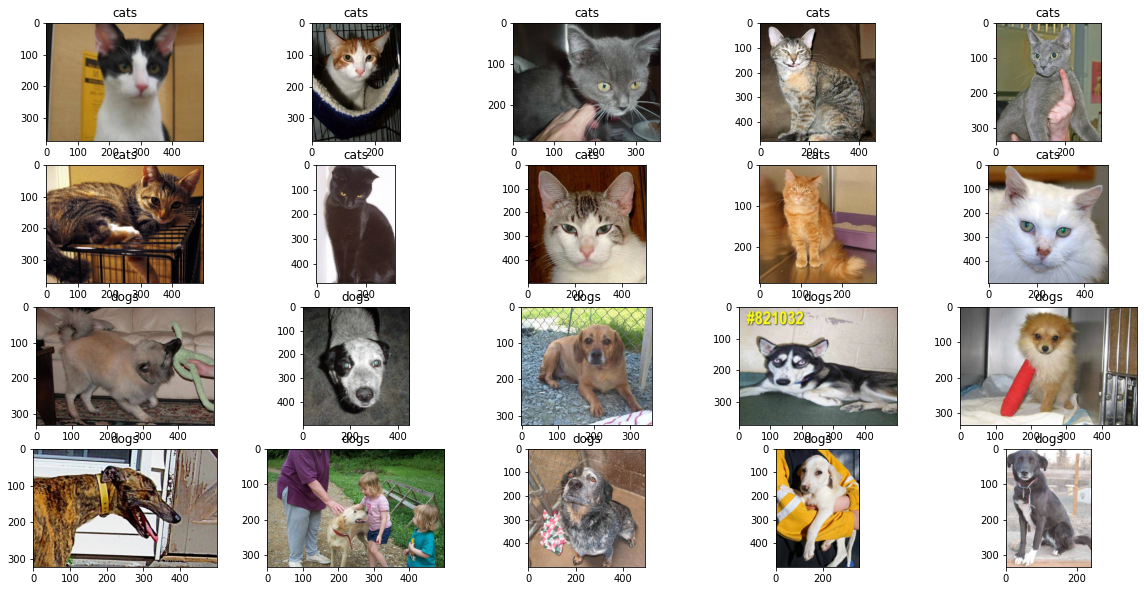

In [20]:
visualize_samples(cats_samples + dogs_samples)

Dari vusialisasi diatas terlihat ukuran gambar yang beragam. Pada cats di dominasi dengan telinga yang keatas, pada dogs telinganya banyak yang kebawah.

In [21]:
cat_img = main_df[main_df['label']=="cats"]
dog_img = main_df[main_df['label']=="dogs"]

Memisahkan cats dan dogs ke dua dataframe berbeda untuk visualisasi.

In [22]:
size_cat = [Image.open(f, 'r').size for f in cat_img['images']]
size_dog = [Image.open(f, 'r').size for f in dog_img['images']]
print("Ukuran terbesar pada cats =",max(size_cat))
print("Ukuran terkecil pada cats =",min(size_cat))
print('-------------------------------------------------------')
print("Ukuran terbesar pada dog =",max(size_dog))
print("Ukuran terkecil pada dog =",min(size_dog))

Ukuran terbesar pada cats = (1023, 768)
Ukuran terkecil pada cats = (59, 41)
-------------------------------------------------------
Ukuran terbesar pada dog = (1050, 702)
Ukuran terkecil pada dog = (57, 50)


Pada ukuran terbesar dan terkecil pada cats dan dogs perbedaannya sangat jauh.

# Splitting Dataset

In [23]:
from sklearn.model_selection import train_test_split
train_df, test_df= train_test_split(main_df, test_size=0.2, random_state=22)
train_df, val_df= train_test_split(train_df, test_size=0.2, random_state=22)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1601, 2)
(5123, 2)
(1281, 2)


Splitting train, test, dan val.

In [24]:
img_height= 220
img_width= 220
SEED = 1
BATCH =32

Menentukan parameter agar semua gambar ukurannya sama semua.

In [25]:
# create image generator

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Proses augmentasi menggunakan ImageDataGenerator untuk melakukan augmentasi gambar. Proses ini juga untuk mengurangi overfitting.

In [51]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

ds_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED)

Found 5123 validated image filenames belonging to 2 classes.
Found 1281 validated image filenames belonging to 2 classes.
Found 1601 validated image filenames belonging to 2 classes.


Proses flow_from_dataframe karena gambar sudah dikonversi ke dataframe. Dengan target size yang sudah ditentukan yaiut 220x220 dan class_mode = binary karena hanya memiliki 2 klasifikasi.

In [27]:
ds_train.class_indices

{'cats': 0, 'dogs': 1}

Mengubah cats menjadi 0, dan dogs menjadi 1.

# Model Definition

In [28]:
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 5, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True)
            #ReduceLROnPlateau
]

Callbacks, model checkpoint, early stopping untuk efficiency training model. Dalam memproses membutuhkan waktu yang lama dan akan berhenti jika val_loss tidak improve. Patience 5 agar efficiencynya lebih baik.

In [29]:
inputs= [img_height,img_width,3]

my_model= Sequential()

#Conv 1
my_model.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
my_model.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
my_model.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
my_model.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
my_model.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
my_model.add(MaxPooling2D(pool_size=2, strides=2))

my_model.add(Flatten())
my_model.add(Dense(units= 128, activation='relu'))
my_model.add(Dense(units=1, activation='sigmoid'))

* Conv 1, menggunakan Conv2D karena akan mengolah data berupa gambah 2 dimesi, menggunakan parameter 16 neuron, dengan kernel_size = 3, relu activation, dan input shape 220,220. Maxpooling 2D dengna jarak pooling 2 pixel dan strides 2.
* Conv 2, Conv2D menggunakan parameter 32 neuron, dengan kernel_size = 3, relu activation, Maxpooling 2D dengna jarak pooling 2 pixel dan strides 2.
* Conv 3, Conv2D menggunakan parameter 64 neuron, dengan kernel_size = 3, relu activation, Maxpooling 2D dengna jarak pooling 2 pixel dan strides 2.
* Flatten pada hasil akhir convulation.
* 1 Layer dengan 128 neuron dan activation relu.
* 1 neuron dengan activation sigmoid karena datanya ada 2 kelas.

In [30]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [31]:
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

Mengunakan binary karena output yang di hasilkan adalah angka biner atau 0 dan 1. evaluasinya dengan accuracy.

# Model Training

In [32]:
%time

history= my_model.fit(ds_train, batch_size= BATCH, 
                           epochs= 10, validation_data= ds_val,
                           callbacks= callbacks, verbose=1)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.5 µs
Epoch 1/10
161/161 [==============================] - 271s 2s/step - loss: 0.7069 - accuracy: 0.5600 - val_loss: 0.6613 - val_accuracy: 0.5925
Epoch 2/10
161/161 [==============================] - 256s 2s/step - loss: 0.6576 - accuracy: 0.6162 - val_loss: 0.6234 - val_accuracy: 0.6206
Epoch 3/10
161/161 [==============================] - 260s 2s/step - loss: 0.6253 - accuracy: 0.6492 - val_loss: 0.5796 - val_accuracy: 0.6987
Epoch 4/10
161/161 [==============================] - 268s 2s/step - loss: 0.6007 - accuracy: 0.6725 - val_loss: 0.6163 - val_accuracy: 0.6128
Epoch 5/10
161/161 [==============================] - 263s 2s/step - loss: 0.5918 - accuracy: 0.6846 - val_loss: 0.5685 - val_accuracy: 0.6932
Epoch 6/10
161/161 [==============================] - 258s 2s/step - loss: 0.5772 - accuracy: 0.7037 - val_loss: 0.5930 - val_accuracy: 0.6635
Epoch 7/10
161/161 [==============================] - 254s 2s/step - loss: 0.5

Training model dengan 10 epoch, 32 batch.

# Model Evaluation

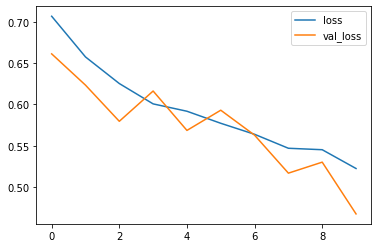

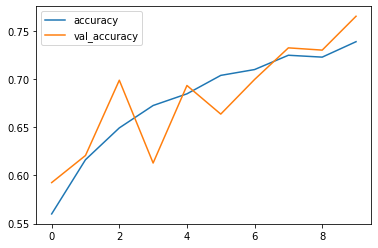

In [33]:
metrics = pd.DataFrame(history.history)
metrics.head()
metrics[['loss','val_loss']].plot();
metrics[['accuracy','val_accuracy']].plot();

* Proses training selesai di epoch 10 berart tidak ada pengaruh early stopping.
* val_loss dan vall acccuracy tidak bagus, tetapi loss dan accuracy cukup bagus dan stabil.
* untuk hasilnya cukup baik atau goodfit.


In [34]:
val_accuracy = np.mean(history.history['accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 67.82%


Accuracy score hanya 67.82%

# Model Improvement

In [36]:
inputs= [img_height,img_width,3]

my_model_imp= Sequential()

#Conv 1
my_model_imp.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
my_model_imp.add(MaxPooling2D(pool_size=2, strides=2))
my_model_imp.add(Dropout(0.2))

#Conv 2
my_model_imp.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
my_model_imp.add(MaxPooling2D(pool_size=2, strides=2))
my_model_imp.add(Dropout(0.2))

#Conv 3
my_model_imp.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
my_model_imp.add(MaxPooling2D(pool_size=2, strides=2))
my_model_imp.add(Dropout(0.2))

my_model_imp.add(Flatten())

my_model_imp.add(Dense(units= 128, activation='relu'))
my_model_imp.add(Dropout(0.2))

my_model_imp.add(Dense(units=1, activation='sigmoid'))

Pada model improvement masih sama dengan model sebebelumnya, hanya di tambahkan dropout 0.2 di setiap layernya.

In [37]:
my_model_imp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 109, 109, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 53, 53, 32)       

In [38]:
my_model_imp.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

Mengunakan binary karena output yang di hasilkan adalah angka biner atau 0 dan 1. evaluasinya dengan accuracy.

In [39]:
%time

history_imp= my_model_imp.fit(ds_train, batch_size= BATCH, 
                           epochs= 20, validation_data= ds_val,
                           callbacks= callbacks, verbose=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.2 µs
Epoch 1/20
161/161 [==============================] - 274s 2s/step - loss: 0.7232 - accuracy: 0.5224 - val_loss: 0.6930 - val_accuracy: 0.5129
Epoch 2/20
161/161 [==============================] - 269s 2s/step - loss: 0.6778 - accuracy: 0.5622 - val_loss: 0.6605 - val_accuracy: 0.6222
Epoch 3/20
161/161 [==============================] - 271s 2s/step - loss: 0.6569 - accuracy: 0.6209 - val_loss: 0.6341 - val_accuracy: 0.6511
Epoch 4/20
161/161 [==============================] - 274s 2s/step - loss: 0.6537 - accuracy: 0.6129 - val_loss: 0.6441 - val_accuracy: 0.6776
Epoch 5/20
161/161 [==============================] - 267s 2s/step - loss: 0.6445 - accuracy: 0.6260 - val_loss: 0.5974 - val_accuracy: 0.6776
Epoch 6/20
161/161 [==============================] - 274s 2s/step - loss: 0.6243 - accuracy: 0.6520 - val_loss: 0.6010 - val_accuracy: 0.6893
Epoch 7/20
161/161 [==============================] - 273s 2s/step - loss: 0.6

Training model dengan 20 epoch, 32 batch.

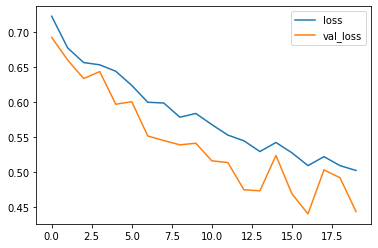

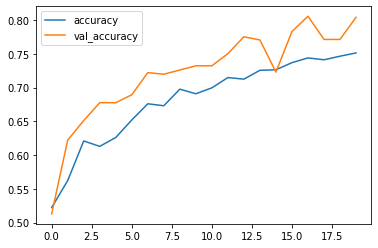

In [40]:
metrics_imp = pd.DataFrame(history_imp.history)
metrics_imp.head()
metrics_imp[['loss','val_loss']].plot();
metrics_imp[['accuracy','val_accuracy']].plot()

Hasil dari model improvement, hasilnya membaik, pada accuraty dan loss, validationnya sudah lebih stabil. training loss nilaina terus menurun sampai dengan epoch 20. Untuk hasilnya terlalu goodfit.

In [41]:
val_accuracy_imp = np.mean(history_imp.history['accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy_imp*100))


val_accuracy: 68.16%


Accuracy score bertambah menjadi 68.16%, nilai accuracynya belum bagus.

# Model Inference

In [44]:
my_model.save('model.h5')

In [45]:
my_model_imp.save('model_imp.h5')

In [52]:
my_model.save('model')

In [43]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

def predict() :
  uploaded = files.upload()

  for fn in uploaded.keys():
 
    # Prediksi dengan mengunggah gambar
    path = fn
    img = image.load_img(path, target_size=(220,220)) #harus sama dengan model kita
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    x = image.img_to_array(img) # untuk ubah image kedalam array
    x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

    images = np.vstack([x])
    classes = my_model_imp.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
    print(classes) 
    if classes[0][0] == 1:
      print('dog')
    else:
      print('cat')

Saving cat.1.jpg to cat.1.jpg


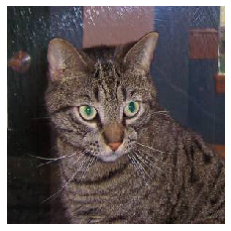

[[0.]]
cat


In [46]:
predict()

Saving cat.2.jpg to cat.2.jpg


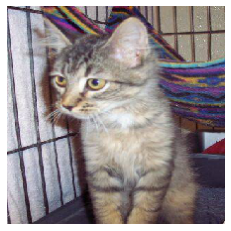

[[0.]]
cat


In [47]:
predict()

Saving dog1.jpg to dog1.jpg


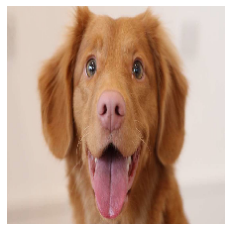

[[1.]]
dog


In [48]:
predict()

Saving dog2.jpg to dog2.jpg


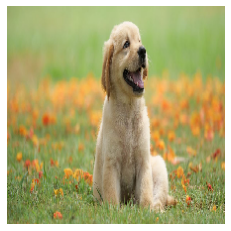

[[1.]]
dog


In [49]:
predict()

Saving dog3.jpeg to dog3.jpeg


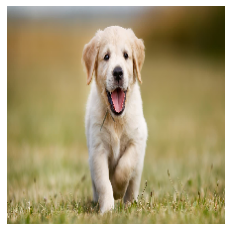

[[1.]]
dog


In [50]:
predict()

# Conclusion

## Model Analysis

Permodelan ini menggunakan dataset yang terdiri dari 2 kelas yaitu cat and dog. Dari data jumlah gambar cat dan dog tidak berbeda signifikan. 
Ukuran pada image:
* Ukuran terbesar pada cats = (1023, 768)
* Ukuran terkecil pada cats = (59, 41)
* Ukuran terbesar pada dog = (1050, 702)
* Ukuran terkecil pada dog = (57, 50)

Pada awal permodelan dilakukan:
* Conv 1, menggunakan Conv2D karena akan mengolah data berupa gambah 2 dimesi, menggunakan parameter 16 neuron, dengan kernel_size = 3, relu activation, dan input shape 220,220. Maxpooling 2D dengna jarak pooling 2 pixel dan strides 2.
* Conv 2, Conv2D menggunakan parameter 32 neuron, dengan kernel_size = 3, relu activation, Maxpooling 2D dengna jarak pooling 2 pixel dan strides 2.
* Conv 3, Conv2D menggunakan parameter 64 neuron, dengan kernel_size = 3, relu activation, Maxpooling 2D dengna jarak pooling 2 pixel dan strides 2.
* Flatten pada hasil akhir convulation.
* 1 Layer dengan 128 neuron dan activation relu.
* 1 neuron dengan activation sigmoid karena datanya ada 2 kelas.

Setelah model di impromve di lakukan:
Pada model improvement masih sama dengan model sebebelumnya, hanya di tambahkan dropout 0.2 di setiap layernya.

Untuk hasil model sebelum di improve: 
* Proses training selesai di epoch 10 berart tidak ada pengaruh early stopping.
* val_loss dan vall acccuracy tidak bagus, tetapi loss dan accuracy cukup bagus dan stabil.
* untuk hasilnya belum cukup goodfit.

Hasil setelah di improve:
* hasilnya membaik, pada accuraty dan loss, validationnya sudah lebih stabil. 
* training loss nilaina terus menurun sampai dengan epoch 20. 
* Untuk hasilnya belum terlalu goodfit.

Setelah dilakukan inference pada model, semua gambar yang di coba terdeteksi dengan benar.

## Advantages

Berdasarkan hasil dari model ini, membantu untuk mengklasifikasi apakah gambar tersebut cat atau dog dengan tidak harus melihat satu-persatu.

## Suggestion

* Untuk permodelan ini hasilnya belum cukup baik karena waktu yang terbatas, untuk selanjutnya bisa menambahkan parameter-parameter lain untuk hasil yang lebih baik.

* Pada dataset ini hanya mengklasifikasi 2 kelas yaitu kucing dan anjing. Sedangkan jenis kucing dan anjing sangat beragam, setiap jenisnya memiliki karakteristik yang berbeda, untuk permodelan selanjutnya mungkin akan menambahkan jenis daripada kusing dan anjing tersebut.





